# IMPORT LIBRARIES 

In [1]:
#imports 
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve)

In [2]:
# Optional XGBOOST import 
try:
    from xgboost import XGBClassifier 
    xgb_avilable = True 
except Exception:
    xgb_avilable = False

print("XGBOOST avilable:", xgb_avilable) 

XGBOOST avilable: True


In [3]:
# loaded datasets 
df = pd.read_csv("titanic.csv.csv")
print("Intital rows:", df.shape[0])
display(df.head())

Intital rows: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_orig = df.copy()
cols_keep = ['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
df = df[cols_keep]

print("\nMissing before fix:\n", df.isnull().sum())


Missing before fix:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [5]:
# Impute numeric columns
num_cols = ['Age','Fare']
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Fill categorical missing with mode
for c in ['Embarked']:
    df[c] = df[c].fillna(df[c].mode()[0])

print("\nMissing after imputation:\n", df.isnull().sum())


Missing after imputation:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [6]:
# Basline features 
baseline = df.copy()
le = LabelEncoder()
baseline['sex_le'] = le.fit_transform(baseline['Sex'])
baseline['embarked_le'] = le.fit_transform(baseline['Embarked'])
baseline_features = ['Pclass','Age','SibSp','Parch','Fare','sex_le','embarked_le']
X_base = baseline[baseline_features]
y = baseline['Survived']

In [7]:
# Engineered features 
df_feat = df.copy()
df_feat['family_size'] = df_feat['SibSp'] + df_feat['Parch'] + 1
df_feat['is_alone'] = np.where(df_feat['family_size'] == 1, 1, 0)
df_feat['fare_per_person'] = df_feat['Fare'] / (df_feat['family_size'] + 1e-6)
df_feat['log_fare'] = np.log1p(df_feat['Fare'])
df_feat['age_group'] = pd.cut(df_feat['Age'], bins=[0,12,20,40,60,100], labels=['child','teen','adult','midage','senior'])
df_feat['age_fare_interaction'] = df_feat['Age'] * df_feat['fare_per_person']

display(df_feat[['family_size','is_alone','fare_per_person','log_fare','age_group','age_fare_interaction']].head())

,family_size,is_alone,fare_per_person,log_fare,age_group,age_fare_interaction
0,2,0,3.624998,2.110213,adult,79.749960
1,2,0,35.641632,4.280593,adult,1354.382023
2,1,1,7.924992,2.188856,adult,206.049794
3,2,0,26.549987,3.990834,adult,929.249535
4,1,1,8.049992,2.202765,adult,281.749718


In [8]:
# Modeling features 
model_df = df_feat.copy()
model_df = pd.get_dummies(model_df, columns=['age_group','Embarked','Sex'], drop_first=True)

engineered_features = [
    'Pclass','Age','SibSp','Parch','Fare',
    'family_size','is_alone','fare_per_person','log_fare',
    'age_fare_interaction'
]
one_hot_cols = [c for c in model_df.columns if ('age_group_' in c) or ('Embarked_' in c) or ('Sex_' in c)]
features_final = engineered_features + one_hot_cols
features_final = [f for f in features_final if f in model_df.columns]

X_eng = model_df[features_final]
y = model_df['Survived']

In [9]:
# Train_test_spilt 
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y, test_size=0.2, random_state=42, stratify=y)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_eng, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Baseline model
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(Xb_train, yb_train)
yb_pred = rf_base.predict(Xb_test)
yb_prob = rf_base.predict_proba(Xb_test)[:,1]

print("\n=== Baseline Random Forest ===")
print("Accuracy:", accuracy_score(yb_test, yb_pred))
print("F1-score:", f1_score(yb_test, yb_pred))
print("ROC AUC:", roc_auc_score(yb_test, yb_prob))


=== Baseline Random Forest ===
Accuracy: 0.8156424581005587
F1-score: 0.7480916030534351
ROC AUC: 0.8296442687747035


In [11]:
# Tunded model 
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=4, scoring='f1', n_jobs=-1)
grid.fit(Xe_train, ye_train)

best = grid.best_estimator_
ye_pred = best.predict(Xe_test)
ye_prob = best.predict_proba(Xe_test)[:,1]

print("\n=== Tuned Random Forest ===")
print("Accuracy:", accuracy_score(ye_test, ye_pred))
print("F1-score:", f1_score(ye_test, ye_pred))
print("ROC AUC:", roc_auc_score(ye_test, ye_prob))


=== Tuned Random Forest ===
Accuracy: 0.8212290502793296
F1-score: 0.7538461538461538
ROC AUC: 0.8233201581027668


In [13]:
# Optional XGBoost import (works if installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

# Optional boost
if xgb_available:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_param = {'n_estimators':[50,100], 'max_depth':[3,5], 'learning_rate':[0.05,0.1]}
    grid_xgb = GridSearchCV(xgb, xgb_param, cv=3, scoring='f1', n_jobs=-1)
    grid_xgb.fit(Xe_train, ye_train)
    xbest = grid_xgb.best_estimator_
    yx_pred = xbest.predict(Xe_test)
    yx_prob = xbest.predict_proba(Xe_test)[:,1]
    print("\n=== XGBoost ===")
    print("Accuracy:", accuracy_score(ye_test, yx_pred))
    print("F1-score:", f1_score(ye_test, yx_pred))
    print("ROC AUC:", roc_auc_score(ye_test, yx_prob))
else:
    print("XGBoost is not available. Please install xgboost to use this section.")



=== XGBoost ===
Accuracy: 0.7932960893854749
F1-score: 0.7131782945736435
ROC AUC: 0.8316205533596839



Top Features:
Sex_male                0.290243
age_fare_interaction    0.132187
fare_per_person         0.109593
Fare                    0.105540
Age                     0.095842
log_fare                0.095272
Pclass                  0.046729
family_size             0.031494
SibSp                   0.022250
Embarked_S              0.017195
dtype: float64


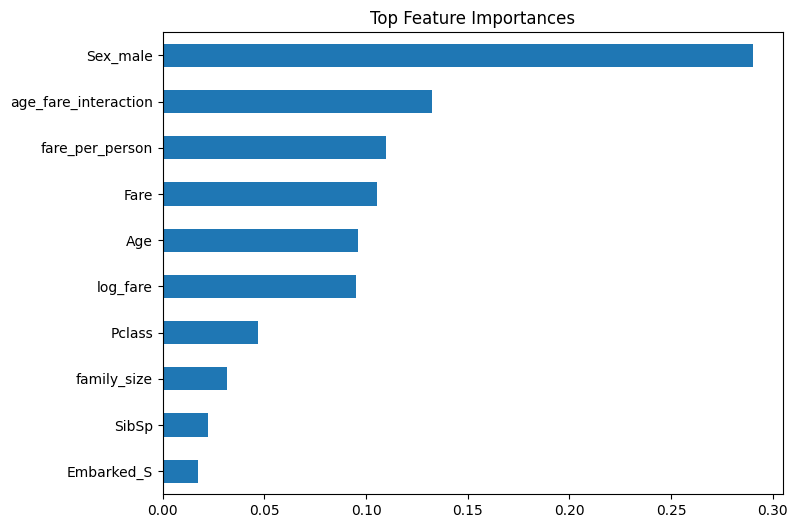

In [14]:
# features importance 
feat_imp = pd.Series(best.feature_importances_, index=Xe_train.columns).sort_values(ascending=False)
print("\nTop Features:")
print(feat_imp.head(10))

plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top Feature Importances")
plt.show()

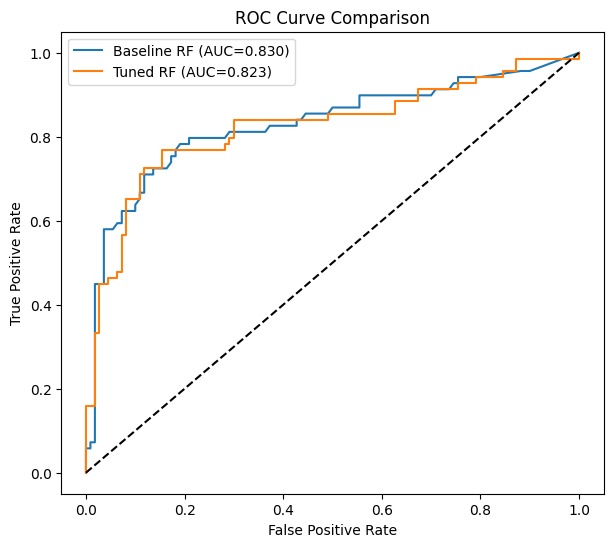

In [15]:
# Roc curve 
fpr_b, tpr_b, _ = roc_curve(yb_test, yb_prob)
fpr_e, tpr_e, _ = roc_curve(ye_test, ye_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr_b, tpr_b, label=f'Baseline RF (AUC={roc_auc_score(yb_test,yb_prob):.3f})')
plt.plot(fpr_e, tpr_e, label=f'Tuned RF (AUC={roc_auc_score(ye_test,ye_prob):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()